<a href="https://colab.research.google.com/github/DanieleFoscarin/NNDL_hw2/blob/main/nndl_2020__homework_2_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 2 - Unsupervised Deep Learning

## General overview
In this homework you will learn how to implement and test neural network models for solving unsupervised problems. For simplicity and to allow continuity with the kind of data you have seen before, the homework will be based on images of handwritten digits (MNIST). However, you can optionally explore different image collections (e.g., [Caltech](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) or [Cifar](https://www.cs.toronto.edu/~kriz/cifar.html)) or other datasets based on your interests. The basic tasks for the homework will require to test and analyze the convolutional autoencoder implemented during the Lab practice. If you prefer, you can opt for a fully-connected autoencoder, which should achieve similar performance considering the relatively small size of the MNIST images. As for the previous homework, you should explore the use of advanced optimizers and regularization methods. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. More advanced tasks will require the exploration of denoising and variational architectures.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework. If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length must not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	1 pt: implement and test (convolutional) autoencoder, reporting the trend of reconstruction loss and some examples of image reconstruction
*	1 pt: explore advanced optimizers and regularization methods 
*	1 pt: optimize hyperparameters using grid/random search and cross-validation
*	1 pt: implement and test denoising (convolutional) autoencoder
*	1 pt: fine-tune the (convolutional) autoencoder using a supervised classification task (you can compare classification accuracy and learning speed with results achieved in homework 1)
*	1 pt: explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes
*	2 pt: implement variational (convolutional) autoencoder or GAN




## Deadline
The complete homework (source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.

#################################################################

In [141]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
!pip install --quiet optuna


In [47]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
from sklearn.decomposition import PCA

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms
import torchvision
import optuna

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
torch.manual_seed(0)

Training device: cuda



# PART 0 Preparing the dataset






get notMNIST dataset from repo
It is the small version

In [50]:
! git clone https://github.com/DanieleFoscarin/NNDL_hw2.git

fatal: destination path 'NNDL_hw2' already exists and is not an empty directory.


In [49]:
! tar xzf  /content/NNDL_hw2/notMNIST_small.tar.gz

Read the folders

In [52]:
ROOT = '/content/notMNIST_small' 
from pathlib import Path
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

images = []
labels = []

#there are few broken files that cannot be read
#not a big problem since they are 5 over 500k
num_label = 0
for folder in sorted(Path(ROOT).iterdir()):
  print(folder)
  for f in folder.iterdir():
    try:     
      img = Image.open(f)
      img_array = np.asarray(img)
      images.append(img_array)
      labels.append(num_label)
    except:
      print("a file was not recognized")
  num_label+=1


images_arr = np.float32(np.array(images))
labels_arr = np.float32(np.array(labels))

#normalize images range
images_arr = images_arr/255

#free up some memory
del images

/content/notMNIST_small/A
a file was not recognized
/content/notMNIST_small/B
/content/notMNIST_small/C
/content/notMNIST_small/D
/content/notMNIST_small/E
/content/notMNIST_small/F
a file was not recognized
/content/notMNIST_small/G
/content/notMNIST_small/H
/content/notMNIST_small/I
/content/notMNIST_small/J


Dictionary for easy interpreation of the labels

In [53]:
letter = {0: 'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'J'}
# print(letter[6])

In [54]:
### Set the random seed for reproducible results
torch.manual_seed(0)

Extend class Dataset

In [55]:
class NMDataset(Dataset):

    def __init__(self, image, label, transform=None):
        self.transform = transform
        self.image = image
        self.label = label

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        #return a nparray from the dataframe
        this_image = self.image[idx]
        this_label = self.label[idx]
        sample = [this_image, this_label]
        if self.transform:
            sample[0] = self.transform(sample[0])
        return sample


    class ToTensor(object):
        """Convert sample to Tensors."""

        def __call__(self, sample):
            x, y = sample
            return (torch.tensor([x]).float(),
                    torch.tensor([y]).float())

to_tensor = torchvision.transforms.ToTensor()   
# composed_transform = transforms.Compose([ToTensor()])
dataset = NMDataset(images_arr, labels_arr, transform=to_tensor)

#check correctness
out = dataset.__getitem__(0)
print(labels_arr[0])


0.0


Split dataset in train, validation, test

In [56]:
length = dataset.__len__()
testval_size = int(np.ceil(length*0.4))
train_size = int(length-testval_size)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, testval_size])

test_size = int(np.ceil(test_dataset.__len__()*0.5))
val_size = int(test_dataset.__len__()-test_size)
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [test_size, val_size])

print(f"train_dataset length {train_dataset.__len__()}")
print(f"val_dataset length {val_dataset.__len__()}")
print(f"test_dataset length {test_dataset.__len__()}")
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_dataset length 11234
val_dataset length 3745
test_dataset length 3745


Show example of the dataset

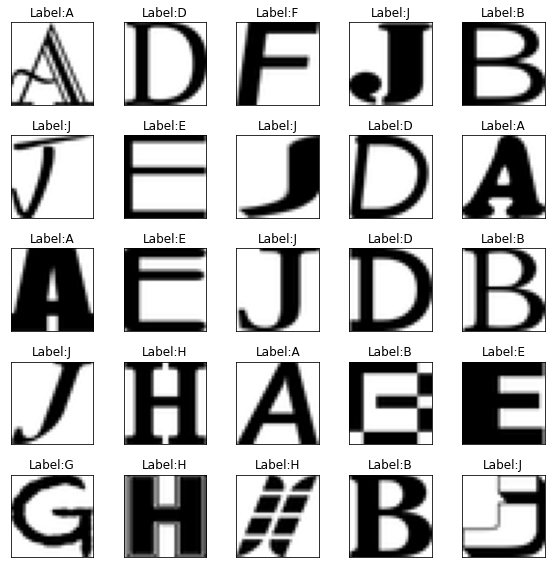

In [58]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(test_dataset)
    img = img.numpy().squeeze()
    ax.imshow(np.array(img), cmap='gray_r')
    ax.set_title(f'Label:{letter[label]}' )
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

# Autoencoder Model Classes

In [59]:
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

same as the lab for now

In [125]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, conv1_ch, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(conv1_ch, conv2_ch, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(conv2_ch, conv3_ch, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * conv3_ch, fc_ch),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(fc_ch, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x


class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, fc_ch),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(fc_ch, 3 * 3 * conv3_ch),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(conv3_ch, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(conv3_ch, conv2_ch, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(conv2_ch, conv1_ch, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(conv1_ch, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

# Training preparation

function for a single epoch training

In [62]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
    
    return loss.data

function for a single epoch inference

In [63]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [64]:

# img, label = test_dataset[0]
# print(np.shape(img))
# print(letter[label])

# Optimized Search with Optuna

Optuna objective function

we need to put the training loop in the level of the objective function, and not as another function, in order to have a functioning trial.report used for pruning

In [129]:
def objective(trial):

    #suggest parameters
    encoded_space_dim = trial.suggest_int('encoded_space_dim', 2,10)
    batch_size = trial.suggest_int('batch_size', 200, 1000)
    optim = trial.suggest_categorical('optim', ['Adam', 'RMSprop'])
    conv1_ch = trial.suggest_categorical('conv1_ch', [32,64,128])
    conv2_ch = trial.suggest_categorical('conv2_ch', [32,64,128])
    conv3_ch = trial.suggest_categorical('conv3_ch', [32,64,128])
    fc_ch = trial.suggest_categorical('fc_ch', [32,64,128])
    
    #make dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # initialize models
    encoder = Encoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)
    decoder = Decoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)

    ### Define the loss function
    loss_fn = torch.nn.MSELoss()

    ### Define an optimizer (both for the encoder and the decoder!)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    if optim == 'Adam':
        optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
    elif optim == 'RMSprop':
        optim = torch.optim.RMSprop(params_to_optimize, lr=lr, weight_decay=1e-5)
    
    
    # Move both the encoder and the decoder to the selected device
    encoder.to(device)
    decoder.to(device)


    # Training Loop
    display = False
    num_epochs = 10 #just smoke test

    train_loss_record = []
    val_loss_record = []
    for epoch in range(num_epochs):
        
        print('EPOCH: %d/%d' % (epoch + 1, num_epochs))

        train_loss_batch_record = []
        val_loss_batch_record = []
        ### Training (use the training function)
        train_loss_batch = train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        train_loss_batch_record.append(train_loss_batch)
        ### Validation  (use the testing function)
        val_loss_batch = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=val_dataloader, 
            loss_fn=loss_fn)
        val_loss_batch_record.append(val_loss_batch)
        if display:
        # Print Validationloss
            print('\n\n\t TRAINING - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, 
                                                                    sum(train_loss_batch_record)/len(train_loss_batch_record)))
            print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss_batch))

        #store losses for this epoch
        train_loss_record.append(sum(train_loss_batch_record)/len(train_loss_batch_record))
        val_loss_record.append(sum(val_loss_batch_record)/len(val_loss_batch_record))

        if display:
            ### Plot progress
            # Get the output of a specific image (the test image at index 0 in this case)
            img = test_dataset[0][0].unsqueeze(0).to(device)
            encoder.eval()
            decoder.eval()
            with torch.no_grad():
                rec_img  = decoder(encoder(img))
            # Plot the reconstructed image
            fig, axs = plt.subplots(1, 2, figsize=(6,3))
            axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gray_r')
            axs[0].set_title('Original image')
            axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray_r')
            axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
            plt.tight_layout()
            plt.pause(0.1)


        # call back optuna for pruning
        trial.report(sum(val_loss_batch_record)/len(val_loss_batch_record), epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
        #end of training loop
    
    final_val_loss = val_loss_record[-1]
    

    
    return final_val_loss

In [130]:
study = optuna.create_study(direction='minimize', 
                            pruner=optuna.pruners.MedianPruner(
                                n_startup_trials=5, n_warmup_steps=5, interval_steps=1))
study.optimize(objective, n_trials=80)

trial = study.best_trial
best_params = trial.params

print('val Loss: {}'.format(trial.value))
print(f"Best hyperparameters: {best_params}")

[I 2020-12-17 23:16:00,843] A new study created in memory with name: no-name-bee471a4-41a2-4a21-921b-22819036f647


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:16:16,745] Trial 0 finished with value: 0.09741444140672684 and parameters: {'encoded_space_dim': 2, 'batch_size': 540, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 32, 'fc_ch': 128, 'lr': 0.0033969945099946346}. Best is trial 0 with value: 0.09741444140672684.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:16:33,187] Trial 1 finished with value: 0.1273082047700882 and parameters: {'encoded_space_dim': 2, 'batch_size': 742, 'optim': 'RMSprop', 'conv1_ch': 32, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 32, 'lr': 0.0006254651885608701}. Best is trial 0 with value: 0.09741444140672684.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:16:48,871] Trial 2 finished with value: 0.19544056057929993 and parameters: {'encoded_space_dim': 4, 'batch_size': 891, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 128, 'conv3_ch': 32, 'fc_ch': 128, 'lr': 0.06377631904717965}. Best is trial 0 with value: 0.09741444140672684.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:17:04,952] Trial 3 finished with value: 0.12865953147411346 and parameters: {'encoded_space_dim': 2, 'batch_size': 804, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 32, 'conv3_ch': 32, 'fc_ch': 128, 'lr': 0.043525986155510905}. Best is trial 0 with value: 0.09741444140672684.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:17:20,339] Trial 4 finished with value: 0.1784965544939041 and parameters: {'encoded_space_dim': 4, 'batch_size': 920, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 32, 'fc_ch': 32, 'lr': 0.0002157217725393312}. Best is trial 0 with value: 0.09741444140672684.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:17:36,159] Trial 5 finished with value: 0.11893802881240845 and parameters: {'encoded_space_dim': 4, 'batch_size': 953, 'optim': 'RMSprop', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 64, 'lr': 0.000632901596788644}. Best is trial 0 with value: 0.09741444140672684.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:17:53,242] Trial 6 finished with value: 0.11622214317321777 and parameters: {'encoded_space_dim': 4, 'batch_size': 974, 'optim': 'RMSprop', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0013567267659066495}. Best is trial 0 with value: 0.09741444140672684.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10


[I 2020-12-17 23:18:02,458] Trial 7 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:18:18,793] Trial 8 finished with value: 0.08123090118169785 and parameters: {'encoded_space_dim': 3, 'batch_size': 952, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 32, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.006587229600386346}. Best is trial 8 with value: 0.08123090118169785.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:18:34,270] Trial 9 finished with value: 0.07881677150726318 and parameters: {'encoded_space_dim': 4, 'batch_size': 861, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 32, 'fc_ch': 32, 'lr': 0.012693611138894638}. Best is trial 9 with value: 0.07881677150726318.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:18:51,479] Trial 10 finished with value: 0.07699602097272873 and parameters: {'encoded_space_dim': 3, 'batch_size': 295, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 64, 'conv3_ch': 32, 'fc_ch': 32, 'lr': 0.01526297905572647}. Best is trial 10 with value: 0.07699602097272873.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:19:09,303] Trial 11 finished with value: 0.0853762999176979 and parameters: {'encoded_space_dim': 3, 'batch_size': 234, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 64, 'conv3_ch': 32, 'fc_ch': 32, 'lr': 0.015052002076093203}. Best is trial 10 with value: 0.07699602097272873.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:19:27,038] Trial 12 finished with value: 0.07065172493457794 and parameters: {'encoded_space_dim': 3, 'batch_size': 221, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 64, 'conv3_ch': 32, 'fc_ch': 32, 'lr': 0.015575680172202271}. Best is trial 12 with value: 0.07065172493457794.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:19:46,406] Trial 13 finished with value: 0.09927204251289368 and parameters: {'encoded_space_dim': 3, 'batch_size': 231, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 32, 'fc_ch': 32, 'lr': 0.028246535382844485}. Best is trial 12 with value: 0.07065172493457794.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10


[I 2020-12-17 23:19:57,113] Trial 14 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:20:15,895] Trial 15 finished with value: 0.0718134269118309 and parameters: {'encoded_space_dim': 3, 'batch_size': 362, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 32, 'lr': 0.006598296789806717}. Best is trial 12 with value: 0.07065172493457794.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:20:34,687] Trial 16 finished with value: 0.07157168537378311 and parameters: {'encoded_space_dim': 3, 'batch_size': 433, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.003984106602425687}. Best is trial 12 with value: 0.07065172493457794.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:20:57,237] Trial 17 finished with value: 0.07449928671121597 and parameters: {'encoded_space_dim': 3, 'batch_size': 512, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.002542568080222467}. Best is trial 12 with value: 0.07065172493457794.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:21:16,170] Trial 18 finished with value: 0.06976893544197083 and parameters: {'encoded_space_dim': 3, 'batch_size': 450, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.004067141408988756}. Best is trial 18 with value: 0.06976893544197083.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10


[I 2020-12-17 23:21:27,810] Trial 19 pruned. 


EPOCH: 1/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10


[I 2020-12-17 23:21:39,081] Trial 20 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:21:58,010] Trial 21 finished with value: 0.0712292268872261 and parameters: {'encoded_space_dim': 3, 'batch_size': 447, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.005347880545992166}. Best is trial 18 with value: 0.06976893544197083.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:22:16,869] Trial 22 finished with value: 0.06950878351926804 and parameters: {'encoded_space_dim': 3, 'batch_size': 454, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.008885802518420733}. Best is trial 22 with value: 0.06950878351926804.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:22:35,355] Trial 23 finished with value: 0.07236379384994507 and parameters: {'encoded_space_dim': 3, 'batch_size': 290, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.011107500329549004}. Best is trial 22 with value: 0.06950878351926804.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10


[I 2020-12-17 23:22:48,856] Trial 24 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:23:07,785] Trial 25 finished with value: 0.07620948553085327 and parameters: {'encoded_space_dim': 3, 'batch_size': 601, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.008515592536339088}. Best is trial 22 with value: 0.06950878351926804.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10


[I 2020-12-17 23:23:19,835] Trial 26 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10


[I 2020-12-17 23:23:29,638] Trial 27 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:23:48,679] Trial 28 finished with value: 0.06911562383174896 and parameters: {'encoded_space_dim': 3, 'batch_size': 203, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.002712022494497767}. Best is trial 28 with value: 0.06911562383174896.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10


[I 2020-12-17 23:24:00,118] Trial 29 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10


[I 2020-12-17 23:24:11,817] Trial 30 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:24:30,891] Trial 31 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:24:49,966] Trial 32 finished with value: 0.07050865143537521 and parameters: {'encoded_space_dim': 3, 'batch_size': 273, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0042171644117672555}. Best is trial 28 with value: 0.06911562383174896.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:25:09,013] Trial 33 finished with value: 0.06894157826900482 and parameters: {'encoded_space_dim': 3, 'batch_size': 266, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.003075949554416587}. Best is trial 33 with value: 0.06894157826900482.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10


[I 2020-12-17 23:25:18,878] Trial 34 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10


[I 2020-12-17 23:25:30,119] Trial 35 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10


[I 2020-12-17 23:25:43,597] Trial 36 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:26:01,235] Trial 37 finished with value: 0.06930284947156906 and parameters: {'encoded_space_dim': 4, 'batch_size': 315, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 64, 'lr': 0.0018811108708875859}. Best is trial 33 with value: 0.06894157826900482.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:26:19,391] Trial 38 finished with value: 0.06890613585710526 and parameters: {'encoded_space_dim': 4, 'batch_size': 259, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.0018004263397705532}. Best is trial 38 with value: 0.06890613585710526.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10


[I 2020-12-17 23:26:29,964] Trial 39 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10


[I 2020-12-17 23:26:40,278] Trial 40 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:26:57,964] Trial 41 finished with value: 0.06804594397544861 and parameters: {'encoded_space_dim': 4, 'batch_size': 310, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.0019358837711779661}. Best is trial 41 with value: 0.06804594397544861.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:27:15,761] Trial 42 finished with value: 0.07111615687608719 and parameters: {'encoded_space_dim': 4, 'batch_size': 310, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.0017960651143079643}. Best is trial 41 with value: 0.06804594397544861.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10


[I 2020-12-17 23:27:30,820] Trial 43 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:27:48,916] Trial 44 finished with value: 0.06113884225487709 and parameters: {'encoded_space_dim': 4, 'batch_size': 256, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.00288987878007245}. Best is trial 44 with value: 0.06113884225487709.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:28:07,211] Trial 45 finished with value: 0.061991967260837555 and parameters: {'encoded_space_dim': 4, 'batch_size': 244, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.002896711506606306}. Best is trial 44 with value: 0.06113884225487709.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10


[I 2020-12-17 23:28:18,119] Trial 46 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:28:36,139] Trial 47 finished with value: 0.06047290936112404 and parameters: {'encoded_space_dim': 4, 'batch_size': 254, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.003207405103926367}. Best is trial 47 with value: 0.06047290936112404.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:28:53,568] Trial 48 finished with value: 0.06029357761144638 and parameters: {'encoded_space_dim': 4, 'batch_size': 347, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.005719063706905056}. Best is trial 48 with value: 0.06029357761144638.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10


[I 2020-12-17 23:29:03,918] Trial 49 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10


[I 2020-12-17 23:29:17,645] Trial 50 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:29:35,773] Trial 51 finished with value: 0.06458292156457901 and parameters: {'encoded_space_dim': 4, 'batch_size': 241, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.0018770658154266893}. Best is trial 48 with value: 0.06029357761144638.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:29:53,666] Trial 52 finished with value: 0.06706051528453827 and parameters: {'encoded_space_dim': 4, 'batch_size': 239, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.006411015425294147}. Best is trial 48 with value: 0.06029357761144638.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:30:11,729] Trial 53 finished with value: 0.06337162107229233 and parameters: {'encoded_space_dim': 4, 'batch_size': 229, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.006235922532460974}. Best is trial 48 with value: 0.06029357761144638.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:30:30,587] Trial 54 finished with value: 0.05946219712495804 and parameters: {'encoded_space_dim': 4, 'batch_size': 202, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.0054578508457935}. Best is trial 54 with value: 0.05946219712495804.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:30:49,554] Trial 55 finished with value: 0.059735897928476334 and parameters: {'encoded_space_dim': 4, 'batch_size': 200, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.005623462762409882}. Best is trial 54 with value: 0.05946219712495804.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:31:08,122] Trial 56 finished with value: 0.05699916183948517 and parameters: {'encoded_space_dim': 4, 'batch_size': 215, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.004817359030850421}. Best is trial 56 with value: 0.05699916183948517.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:31:26,041] Trial 57 finished with value: 0.05738474056124687 and parameters: {'encoded_space_dim': 4, 'batch_size': 210, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.005082341610287804}. Best is trial 56 with value: 0.05699916183948517.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:31:44,132] Trial 58 finished with value: 0.058704134076833725 and parameters: {'encoded_space_dim': 4, 'batch_size': 203, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.004560798504416798}. Best is trial 56 with value: 0.05699916183948517.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:32:02,087] Trial 59 finished with value: 0.06072580814361572 and parameters: {'encoded_space_dim': 4, 'batch_size': 211, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.011210184180482577}. Best is trial 56 with value: 0.05699916183948517.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:32:20,029] Trial 60 finished with value: 0.057734426110982895 and parameters: {'encoded_space_dim': 4, 'batch_size': 202, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.004889306574707802}. Best is trial 56 with value: 0.05699916183948517.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:32:37,910] Trial 61 finished with value: 0.05676792189478874 and parameters: {'encoded_space_dim': 4, 'batch_size': 203, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.004624271070741722}. Best is trial 61 with value: 0.05676792189478874.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:32:55,911] Trial 62 finished with value: 0.056810904294252396 and parameters: {'encoded_space_dim': 4, 'batch_size': 203, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.0048421427434013975}. Best is trial 61 with value: 0.05676792189478874.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:33:13,189] Trial 63 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:33:31,372] Trial 64 finished with value: 0.05808280035853386 and parameters: {'encoded_space_dim': 4, 'batch_size': 203, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.004429174336634924}. Best is trial 61 with value: 0.05676792189478874.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:33:49,145] Trial 65 finished with value: 0.05789756402373314 and parameters: {'encoded_space_dim': 4, 'batch_size': 221, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.004508521335728143}. Best is trial 61 with value: 0.05676792189478874.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:34:06,733] Trial 66 finished with value: 0.056627027690410614 and parameters: {'encoded_space_dim': 4, 'batch_size': 226, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.004527045506417478}. Best is trial 66 with value: 0.056627027690410614.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:34:23,819] Trial 67 finished with value: 0.0598241426050663 and parameters: {'encoded_space_dim': 4, 'batch_size': 282, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.007553836116276167}. Best is trial 66 with value: 0.056627027690410614.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:34:41,632] Trial 68 finished with value: 0.0588412843644619 and parameters: {'encoded_space_dim': 4, 'batch_size': 222, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 32, 'fc_ch': 128, 'lr': 0.009587590566387283}. Best is trial 66 with value: 0.056627027690410614.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10


[I 2020-12-17 23:34:51,085] Trial 69 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10


[I 2020-12-17 23:35:01,429] Trial 70 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:35:19,242] Trial 71 finished with value: 0.05857696384191513 and parameters: {'encoded_space_dim': 4, 'batch_size': 223, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.004167422140772307}. Best is trial 66 with value: 0.056627027690410614.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:35:37,350] Trial 72 finished with value: 0.05741768330335617 and parameters: {'encoded_space_dim': 4, 'batch_size': 200, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.004655635889803158}. Best is trial 66 with value: 0.056627027690410614.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:35:54,297] Trial 73 finished with value: 0.05987756326794624 and parameters: {'encoded_space_dim': 4, 'batch_size': 294, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.0036810730605026307}. Best is trial 66 with value: 0.056627027690410614.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:36:12,333] Trial 74 finished with value: 0.05705324932932854 and parameters: {'encoded_space_dim': 4, 'batch_size': 225, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.006997176500296692}. Best is trial 66 with value: 0.056627027690410614.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:36:30,063] Trial 75 finished with value: 0.062073659151792526 and parameters: {'encoded_space_dim': 4, 'batch_size': 276, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.013559204595858274}. Best is trial 66 with value: 0.056627027690410614.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10
EPOCH: 7/10
EPOCH: 8/10
EPOCH: 9/10
EPOCH: 10/10


[I 2020-12-17 23:36:48,221] Trial 76 finished with value: 0.0623079352080822 and parameters: {'encoded_space_dim': 4, 'batch_size': 227, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 32, 'lr': 0.010597860895536498}. Best is trial 66 with value: 0.056627027690410614.


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10


[I 2020-12-17 23:36:58,775] Trial 77 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10


[I 2020-12-17 23:37:09,307] Trial 78 pruned. 


EPOCH: 1/10
EPOCH: 2/10
EPOCH: 3/10
EPOCH: 4/10
EPOCH: 5/10
EPOCH: 6/10


[I 2020-12-17 23:37:18,708] Trial 79 pruned. 


val Loss: 0.056627027690410614
Best hyperparameters: {'encoded_space_dim': 4, 'batch_size': 226, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.004527045506417478}


In [131]:
best_params = trial.params
print(best_params)

{'encoded_space_dim': 4, 'batch_size': 226, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.004527045506417478}


In [147]:
# print(study.trials)
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_conv1_ch,params_conv2_ch,params_conv3_ch,params_encoded_space_dim,params_fc_ch,params_lr,params_optim,state
0,0,0.097414,2020-12-17 23:16:00.847276,2020-12-17 23:16:16.745201,0 days 00:00:15.897925,540,64,64,32,2,128,0.003397,Adam,COMPLETE
1,1,0.127308,2020-12-17 23:16:16.746680,2020-12-17 23:16:33.186792,0 days 00:00:16.440112,742,32,32,64,2,32,0.000625,RMSprop,COMPLETE
2,2,0.195441,2020-12-17 23:16:33.188216,2020-12-17 23:16:48.870667,0 days 00:00:15.682451,891,32,128,32,4,128,0.063776,Adam,COMPLETE
3,3,0.128660,2020-12-17 23:16:48.872030,2020-12-17 23:17:04.951881,0 days 00:00:16.079851,804,128,32,32,2,128,0.043526,Adam,COMPLETE
4,4,0.178497,2020-12-17 23:17:04.953301,2020-12-17 23:17:20.339157,0 days 00:00:15.385856,920,64,32,32,4,32,0.000216,Adam,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,75,0.062074,2020-12-17 23:36:12.335185,2020-12-17 23:36:30.062841,0 days 00:00:17.727656,276,64,128,64,4,128,0.013559,Adam,COMPLETE
76,76,0.062308,2020-12-17 23:36:30.064371,2020-12-17 23:36:48.220757,0 days 00:00:18.156386,227,64,32,64,4,32,0.010598,Adam,COMPLETE
77,77,0.099342,2020-12-17 23:36:48.222208,2020-12-17 23:36:58.775684,0 days 00:00:10.553476,242,64,32,64,4,128,0.006799,RMSprop,PRUNED
78,78,0.074818,2020-12-17 23:36:58.776872,2020-12-17 23:37:09.307361,0 days 00:00:10.530489,272,64,32,64,4,128,0.002296,Adam,PRUNED


visualization optuna

In [132]:
optuna.visualization.plot_optimization_history(study)

In [133]:
optuna.visualization.plot_slice(study)

train a model with the best parameters

EPOCH: 1/10


	 TRAINING - EPOCH 1/10 - loss: 0.114893




	 VALIDATION - EPOCH 1/10 - loss: 0.111913




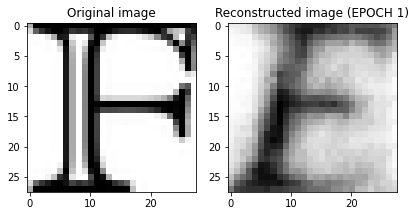

EPOCH: 2/10


	 TRAINING - EPOCH 2/10 - loss: 0.088744




	 VALIDATION - EPOCH 2/10 - loss: 0.086497




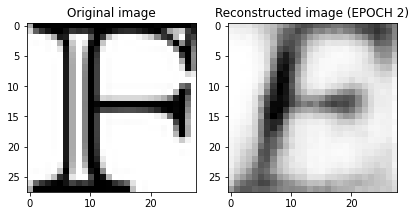

EPOCH: 3/10


	 TRAINING - EPOCH 3/10 - loss: 0.066957




	 VALIDATION - EPOCH 3/10 - loss: 0.073320




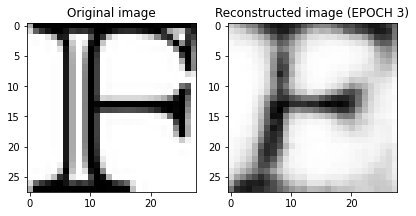

EPOCH: 4/10


	 TRAINING - EPOCH 4/10 - loss: 0.070783




	 VALIDATION - EPOCH 4/10 - loss: 0.068470




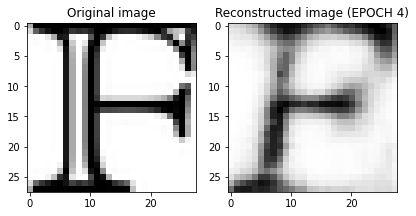

EPOCH: 5/10


	 TRAINING - EPOCH 5/10 - loss: 0.059823




	 VALIDATION - EPOCH 5/10 - loss: 0.064876




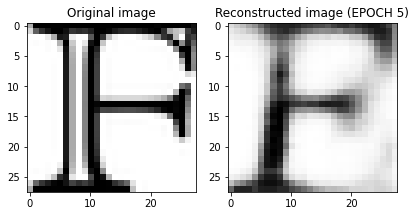

EPOCH: 6/10


	 TRAINING - EPOCH 6/10 - loss: 0.058357




	 VALIDATION - EPOCH 6/10 - loss: 0.063182




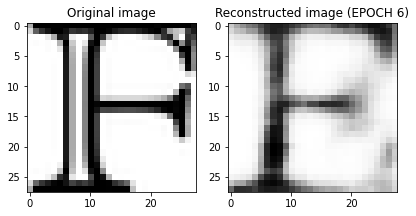

EPOCH: 7/10


	 TRAINING - EPOCH 7/10 - loss: 0.058415




	 VALIDATION - EPOCH 7/10 - loss: 0.061225




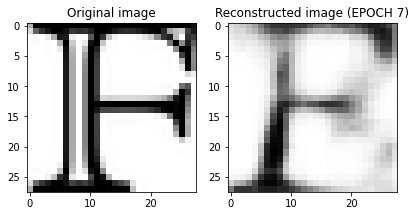

EPOCH: 8/10


	 TRAINING - EPOCH 8/10 - loss: 0.060904




	 VALIDATION - EPOCH 8/10 - loss: 0.060747




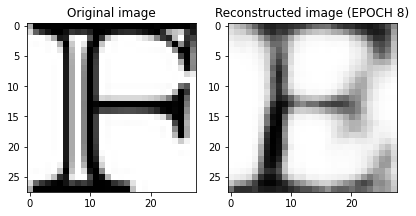

EPOCH: 9/10


	 TRAINING - EPOCH 9/10 - loss: 0.056522




	 VALIDATION - EPOCH 9/10 - loss: 0.058919




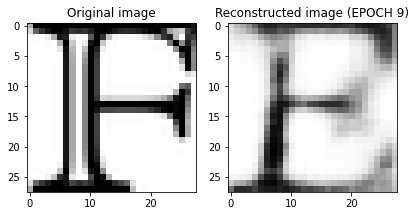

EPOCH: 10/10


	 TRAINING - EPOCH 10/10 - loss: 0.051874




	 VALIDATION - EPOCH 10/10 - loss: 0.058877




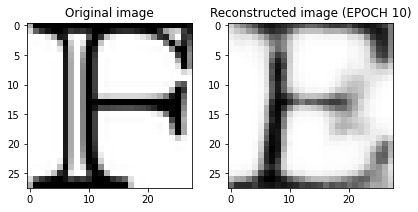

In [144]:
encoded_space_dim = best_params['encoded_space_dim']
batch_size = best_params['batch_size']
lr = best_params['lr']
optim = best_params['optim']

conv1_ch = best_params['conv1_ch']
conv2_ch = best_params['conv2_ch']
conv3_ch = best_params['conv3_ch']
fc_ch = best_params['fc_ch']

#make dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# initialize models
encoder = Encoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)
decoder = Decoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
if optim == 'Adam':
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
elif optim == 'RMSprop':
    optim = torch.optim.RMSprop(params_to_optimize, lr=lr, weight_decay=1e-5)


# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


# Training Loop
display = True
num_epochs = 10

train_loss_record = []
val_loss_record = []
for epoch in range(num_epochs):
    
    print('EPOCH: %d/%d' % (epoch + 1, num_epochs))

    train_loss_batch_record = []
    val_loss_batch_record = []
    ### Training (use the training function)
    train_loss_batch = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    train_loss_batch_record.append(train_loss_batch)
    ### Validation  (use the testing function)
    val_loss_batch = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn)
    val_loss_batch_record.append(val_loss_batch)
    if display:
    # Print Validationloss
        print('\n\n\t TRAINING - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, 
                                                                sum(train_loss_batch_record)/len(train_loss_batch_record)))
        print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss_batch))

    #store losses for this epoch
    train_loss_record.append(sum(train_loss_batch_record)/len(train_loss_batch_record))
    val_loss_record.append(sum(val_loss_batch_record)/len(val_loss_batch_record))

    if display:
        ### Plot progress
        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset[0][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        # Plot the reconstructed image
        fig, axs = plt.subplots(1, 2, figsize=(6,3))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gray_r')
        axs[0].set_title('Original image')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray_r')
        axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.pause(0.1)


In [145]:
best_encoder = encoder
best_decoder = decoder

## Examples of reconstructed samples

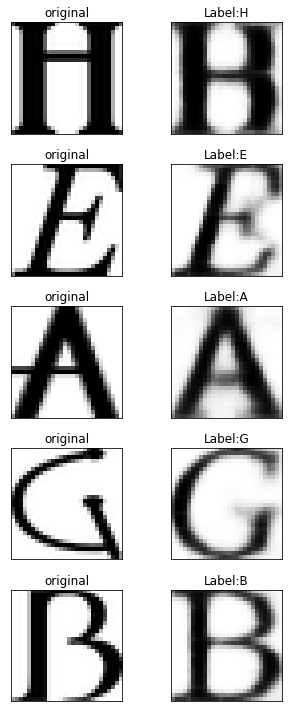

In [146]:
rows = 5
fig, ax = plt.subplots(5, 2, figsize=(rows,rows*2))
for i in range(rows):
    img, label = random.choice(test_dataset)
    img = img.unsqueeze(0).to(device)
    best_encoder.eval()
    best_decoder.eval()
    with torch.no_grad():
        rec_img  = best_decoder(best_encoder(img))
    ax[i,0].imshow(img.cpu().squeeze().numpy(), cmap='gray_r')
    ax[i,0].set_title('original')
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    ax[i,1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray_r')
    ax[i,1].set_title(f'Label:{letter[label]}' )
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])
plt.tight_layout()

# Latent space analysis

In [ ]:
# # Load network parameters
# encoder.load_state_dict(torch.load('encoder_params.pth'))
# decoder.load_state_dict(torch.load('decoder_params.pth'))

Function for generation of encoded samples

In [111]:
### Get the encoded representation of the test samples
def make_encoded_samples(dataset, encoder, device):
    encoded_samples = []
    for sample in tqdm(dataset):
        img = sample[0].unsqueeze(0).to(device)
        label = sample[1]
        # Encode image
        encoder.eval()
        with torch.no_grad():
            encoded_img  = encoder(img)
        # Append to list
        encoded_img = encoded_img.flatten().cpu().numpy()
        encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
        encoded_sample['label'] = letter[label]
        encoded_samples.append(encoded_sample)
    
    return encoded_samples

In [112]:
encoded_samples = make_encoded_samples(test_dataset, best_encoder, device)


100%|██████████| 3745/3745 [00:02<00:00, 1497.54it/s]


In [117]:
print(np.shape(encoded_samples))

(3745, 5)


## Encoded examples

In [ ]:
# print(type(encoded_samples))
# print(np.shape(encoded_samples))
# print(encoded_samples[0])

<class 'list'>
(3745,)
{'Enc. Variable 0': 26.27268, 'Enc. Variable 1': -8.605742, 'Enc. Variable 2': -4.129607, 'label': 5.0}


In [113]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,-3.761011,-3.001113,-5.677158,-3.534796,F
1,-0.177390,9.665394,1.975779,1.600593,H
2,-4.680666,12.415443,-1.701374,0.636065,H
3,-0.329507,3.604633,-11.455734,1.353911,G
4,1.966577,8.913950,-6.161337,-11.338642,D
...,...,...,...,...,...
3740,-2.343079,3.783724,-11.198976,3.550624,C
3741,0.027288,-0.223625,-7.796255,-6.583548,D
3742,-3.086390,7.891299,-2.491598,-4.142018,H
3743,-8.576359,-1.682017,7.367033,-6.405891,J


## PCA if dim > 2

In [114]:
if encoded_space_dim > 2:
    PCAobj = PCA(n_components=2)
    PCAobj.fit(encoded_samples.iloc[:,0:encoded_space_dim])
    encoded_samples_reduced = PCAobj.transform(encoded_samples.iloc[:,0:encoded_space_dim])

    encoded_samples_reduced = pd.DataFrame(encoded_samples_reduced)
    # encoded_samples_reduced.insert(encoded_space_dim, "label", encoded_samples["label"], True)
    encoded_samples_reduced['label'] = encoded_samples['label']
    encoded_samples_reduced.columns = ['Enc. Variable 0', 'Enc. Variable 1', 'label']
    encoded_samples_reduced

    # print(PCAobj.explained_variance_ratio_)
    # print(type(encoded_samples_reduced))
    # print(np.shape(encoded_samples_reduced))
else:
    encoded_samples_reduced = encoded_samples
    print("no need for PCA")
    

In [115]:
encoded_samples_reduced

,Enc. Variable 0,Enc. Variable 1,label
0,-1.117078,-4.228733,F
1,2.604879,8.235542,H
2,0.917114,10.803856,H
3,-8.326650,3.242149,G
4,3.803149,7.918033,D
...,...,...,...
3740,-9.271940,3.282143,C
3741,-1.007177,-1.053270,D
3742,2.659192,6.375285,H
3743,11.396126,-4.465239,J


This graph shows where each input image is mapped in the encoded space. Since we have just 2 encoded variables, we can easily plot them in a bidimensional space. 

In [116]:
import plotly.express as px
px.scatter(encoded_samples_reduced, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

# PART 2 Denoising autoencoder